In [5]:
#installing libraries

install.packages("janitor")
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(janitor)
library(repr)
library(tidymodels)
install.packages('kknn')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [49]:
#Our dataset can successfully be loaded into R

stroke_original <- read_csv('stroke_prediction_dataset.csv') |> 
    clean_names()

head(stroke_original, 5)

#We selected the relevant variables and the top 5000 rows.
stroke <- stroke_original |> 
    select(average_glucose_level, body_mass_index_bmi, diagnosis) |> 
    slice(1:4000)

head(stroke, 5)
nrow(stroke)

Rows: 15000 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): Patient Name, Gender, Marital Status, Work Type, Residence Type, S...
dbl  (8): Patient ID, Age, Hypertension, Heart Disease, Average Glucose Leve...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


patient_id,patient_name,age,gender,hypertension,heart_disease,marital_status,work_type,residence_type,average_glucose_level,⋯,alcohol_intake,physical_activity,stroke_history,family_history_of_stroke,dietary_habits,stress_levels,blood_pressure_levels,cholesterol_levels,symptoms,diagnosis
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,⋯,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,⋯,Never,Low,0,No,Paleo,1.73,146/91,"HDL: 63, LDL: 70","Loss of Balance, Headache, Dizziness, Confusion",Stroke
32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,⋯,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,⋯,Frequent Drinker,Moderate,0,No,Paleo,5.35,174/81,"HDL: 70, LDL: 137","Seizures, Blurred Vision, Severe Fatigue, Headache, Confusion",No Stroke
48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,⋯,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke


average_glucose_level,body_mass_index_bmi,diagnosis
<dbl>,<dbl>,<chr>
130.91,22.37,Stroke
183.73,32.57,Stroke
189.00,20.32,Stroke
185.29,27.50,No Stroke
177.34,29.06,Stroke


[1] 4000

In [50]:
#setting the seed 
set.seed(12345)

#splitting the dataset into testing and training sets 

stroke <- mutate(stroke, diagnosis = as_factor(diagnosis))

stroke_split <- initial_split(stroke, prop = 0.75, strata = diagnosis)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

head(stroke_train, 3)
nrow(stroke_train)
head(stroke_test, 3)
nrow(stroke_test)

average_glucose_level,body_mass_index_bmi,diagnosis
<dbl>,<dbl>,<fct>
185.29,27.50,No Stroke
94.90,36.74,No Stroke
136.06,25.19,No Stroke


[1] 2999

average_glucose_level,body_mass_index_bmi,diagnosis
<dbl>,<dbl>,<fct>
177.34,29.06,Stroke
77.83,28.20,No Stroke
72.99,30.10,Stroke


[1] 1001

In [51]:
#Cross Validation -What is the best K 


#Splitting our training set in preperation for cross validation. 
validation_split <- initial_split(stroke_train, prop = 0.75, strata = diagnosis) 
stroke_subtrain <- training(validation_split) 
stroke_validation <- testing(validation_split)

#Create the standardization recipe 
stroke_recipe_validation <- recipe(diagnosis ~ ., data = stroke_subtrain) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 

#Create Model 
knn_spec_validation <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |> 
    set_engine('kknn') |> 
    set_mode('classification') 

#Create workflow
knn_fit_validation <- workflow() |> 
    add_recipe(stroke_recipe_validation) |> 
    add_model(knn_spec_validation) |> 
    fit(data = stroke_validation)

Warning message:
“tune samples were requested but there were 750 rows in the data. 745 will be used.”


In [52]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5)) 

#creating the vfold 
stroke_vfold <- vfold_cv(stroke_train, v = 5, strata = diagnosis) 


knn_results <- workflow() |> 
    add_recipe(stroke_recipe_validation) |> 
    add_model(knn_spec_validation) |> 
    tune_grid(resamples = stroke_vfold, grid = k_vals) |> 
    collect_metrics()

In [53]:
accuracies <- knn_results |> 
    filter(.metric == 'accuracy')|> 
    arrange(by = desc(mean)) 

head(accuracies, 5)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
81,accuracy,binary,0.5231669,5,0.006699685,Preprocessor1_Model17
86,accuracy,binary,0.5204964,5,0.009502983,Preprocessor1_Model18
41,accuracy,binary,0.5185064,5,0.008836600,Preprocessor1_Model09
96,accuracy,binary,0.5174992,5,0.007897434,Preprocessor1_Model20
36,accuracy,binary,0.5158370,5,0.005551964,Preprocessor1_Model08


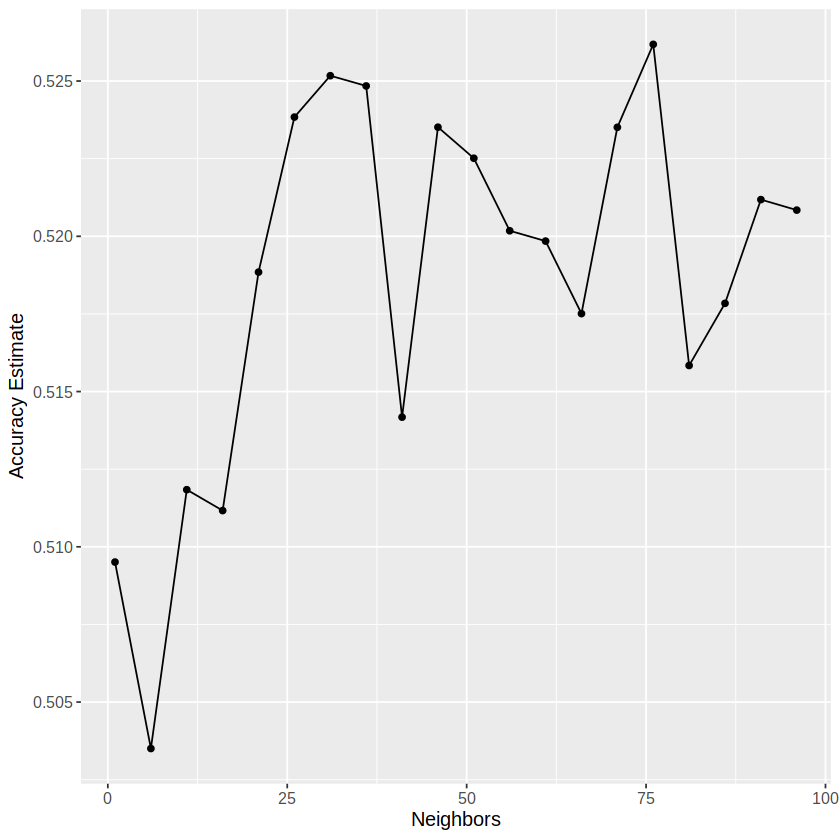

In [25]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

#We can see that the K = 81 has the best accuracy. 

In [59]:
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 81) |> 
    set_engine('kknn') |> 
    set_mode('classification') 

knn_recipe <- recipe(diagnosis ~ ., data = stroke_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 
                     
knn_workflow <- workflow() |> 
    add_recipe(knn_recipe) |> 
    add_model(knn_spec) |>
    fit(data = stroke_train) 
                     
stroke_predictions <- predict(knn_workflow, stroke_test) |> 
    bind_cols(stroke_test) 
                     
head(stroke_predictions, 5)

.pred_class,average_glucose_level,body_mass_index_bmi,diagnosis
<fct>,<dbl>,<dbl>,<fct>
Stroke,177.34,29.06,Stroke
No Stroke,77.83,28.20,No Stroke
Stroke,72.99,30.10,Stroke
No Stroke,111.23,28.83,No Stroke
Stroke,72.85,37.58,No Stroke


In [61]:
prediction_accuracy <- stroke_predictions |> 
    metrics(truth = diagnosis, estimate = .pred_class)

prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.50849151
kap,binary,0.01682112


In [63]:
confusion_matrix <- stroke_predictions |> 
    conf_mat(truth = diagnosis, estimate = .pred_class)

confusion_matrix

           Truth
Prediction  Stroke No Stroke
  Stroke       248       245
  No Stroke    247       261

In [67]:
correct_labels <- 248 + 261
incorrect_labels <- 247 + 245

accuracy <- correct_labels / (correct_labels + incorrect_labels) 
precision <- 248 / (248 + 245) 
recall <- 248 / (248 + 247)

accuracy 
precision
recall

[1] 0.5084915

[1] 0.5030426

[1] 0.5010101

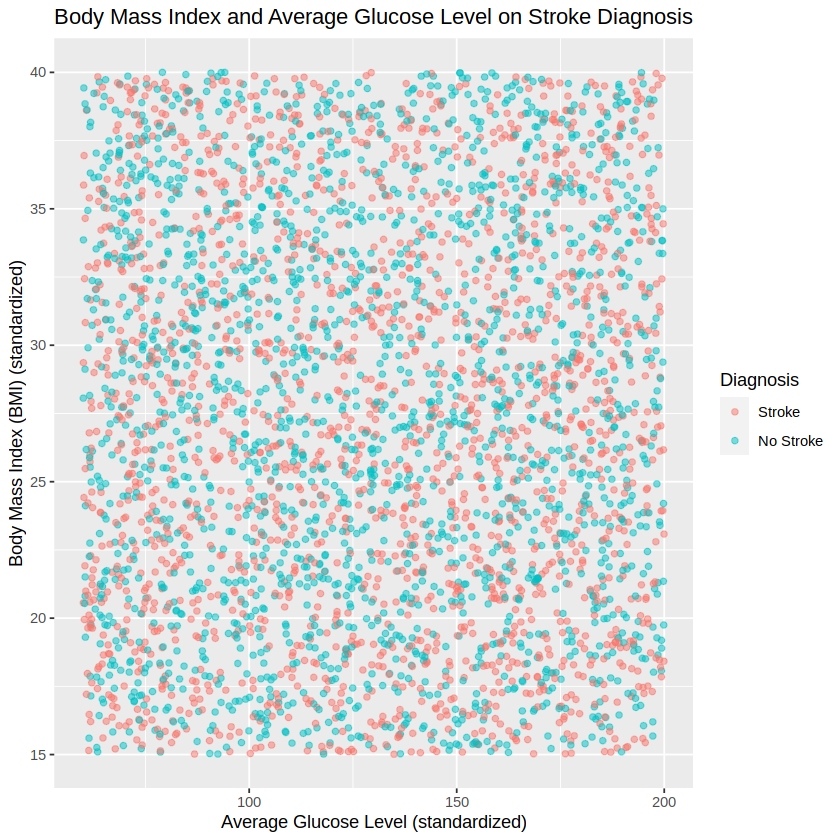

In [73]:
visualization <- stroke |> 
    ggplot(aes(x = average_glucose_level, y = body_mass_index_bmi, color = diagnosis)) + 
    geom_point(alpha = 0.5) + 
    labs(x = 'Average Glucose Level (standardized)', y = 'Body Mass Index (BMI) (standardized)', color = 'Diagnosis') + 
    ggtitle('Body Mass Index and Average Glucose Level on Stroke Diagnosis')

visualization